In [18]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('WAG_C_M.csv', sep=';', parse_dates=['month'], index_col=['month'], dayfirst=True)
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


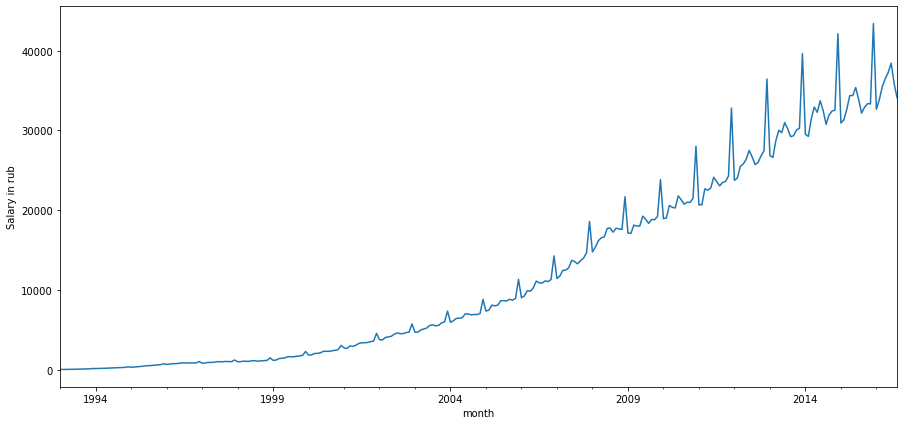

In [3]:
#проведем визуальный анализ ряда
plt.figure(figsize=(15, 7))
plt.ylabel('Salary in rub')
data['WAG_C_M'].plot();

Видим ярко выраженные тренд и сезонность, также видим, что дисперсия со временем меняется. Проверим предположение с помощью STL-декомпозиции

Критерий Дики-Фуллера: 0.9918495954854734


<Figure size 1080x1080 with 0 Axes>

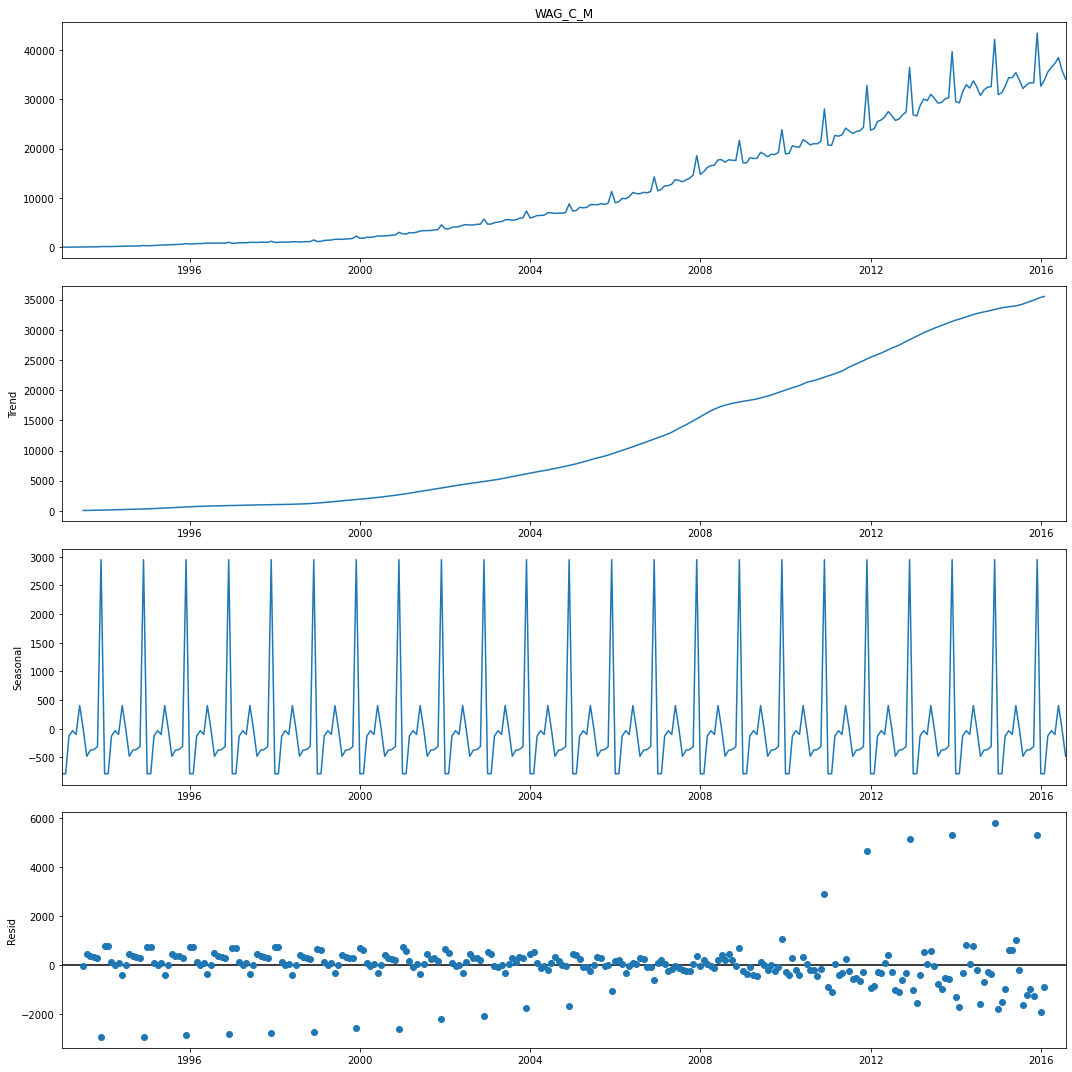

In [4]:
plt.figure(figsize(15, 15));
sm.tsa.seasonal_decompose(data['WAG_C_M']).plot();
print('Критерий Дики-Фуллера: {}'.format(sm.tsa.stattools.adfuller(data['WAG_C_M'])[1]))

С помощью STL-декомпозиции подтверждаем гипотезу. Проведем стабилизацию дисперсии преобразованием Бокса-Кокса

Оптимальный параметр для преобразования Бокса-Кокса = 0.2632017541844584
Критерий Дики-Фуллера = 0.6968987634832777


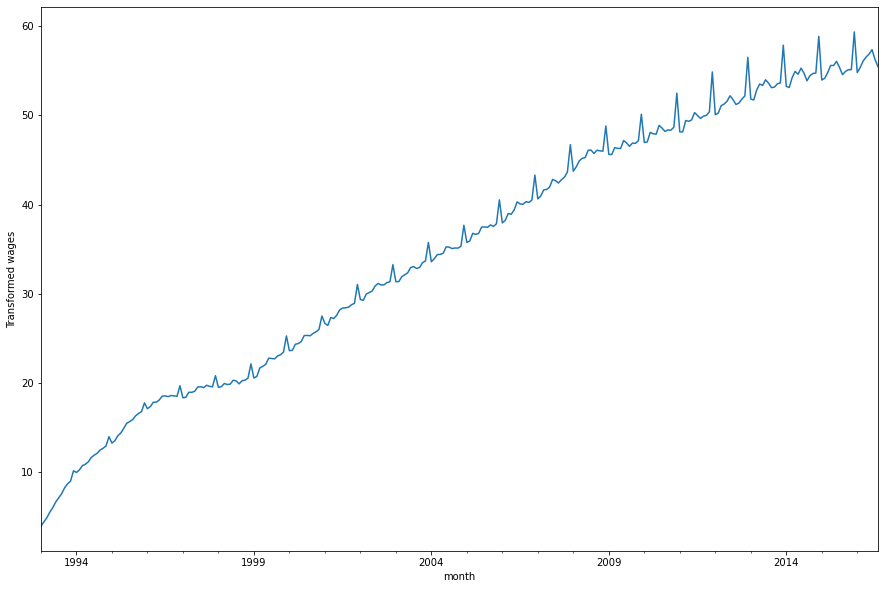

In [5]:
data['WAG_C_M_boxcox'], lmbd = stats.boxcox(data['WAG_C_M'])
plt.figure(figsize(15, 10))
data['WAG_C_M_boxcox'].plot();
plt.ylabel('Transformed wages')
print('Оптимальный параметр для преобразования Бокса-Кокса = {}'.format(lmbd))
print('Критерий Дики-Фуллера = {}'.format(sm.tsa.stattools.adfuller(data['WAG_C_M_boxcox'])[1]))

Критерий Дики-Фуллера отвергает гипотезу о нестационарности ряда, и по графику виден ярко выраженный тренд. Проведем дифференцирование. Начнем с сезоного, сезон составляет 12 месяцев. Сразу проверим с помощью STL-декомпозиции

Критерий Дики-Фуллера: 0.014697133494791847


<Figure size 1080x720 with 0 Axes>

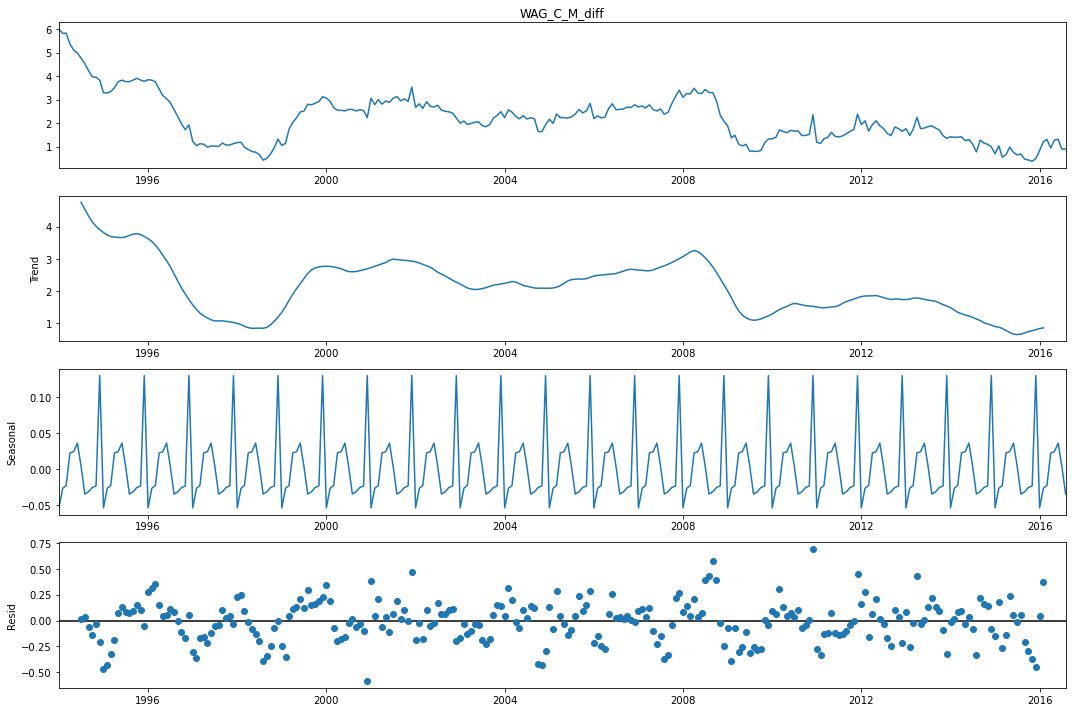

In [6]:
data['WAG_C_M_diff'] = data['WAG_C_M_boxcox'] - data['WAG_C_M_boxcox'].shift(12)
plt.figure(figsize(15, 10));
sm.tsa.seasonal_decompose(data['WAG_C_M_diff'][12:]).plot();
print('Критерий Дики-Фуллера: {}'.format(sm.tsa.stattools.adfuller(data['WAG_C_M_diff'][12:])[1]))

Тренд потерял много структуры, но все еще заметен. Проведем обычное дифференцирование

Критерий Дики-Фуллера: 5.203603715821878e-08


<Figure size 1080x720 with 0 Axes>

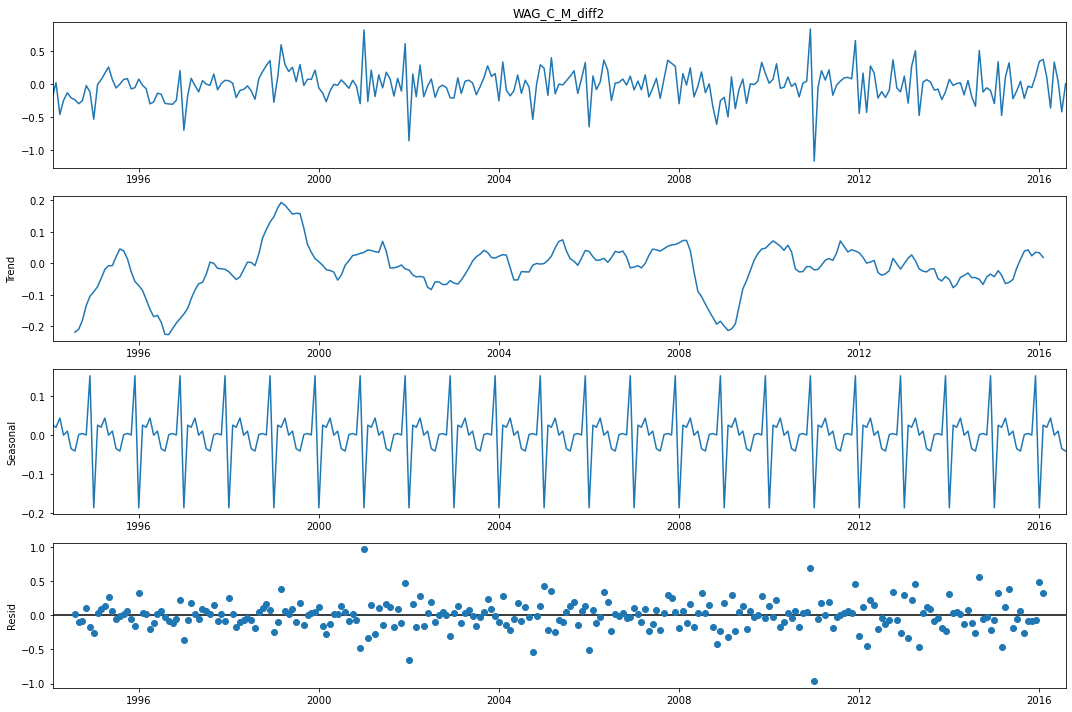

In [7]:
data['WAG_C_M_diff2'] = data['WAG_C_M_diff'] - data['WAG_C_M_diff'].shift(1)
plt.figure(figsize(15, 10));
sm.tsa.seasonal_decompose(data['WAG_C_M_diff2'][13:]).plot();
print('Критерий Дики-Фуллера: {}'.format(sm.tsa.stattools.adfuller(data['WAG_C_M_diff2'][13:])[1]))

Критерий Дики-Фуллера не отвергает гипотезу о нестационарности ряда и по графику видно, что тренд потерял структуру. Посмотрим на графики автокорреляции и частичной автокорреляции, чтобы выбрать начальные приближения для p, q, P, Q

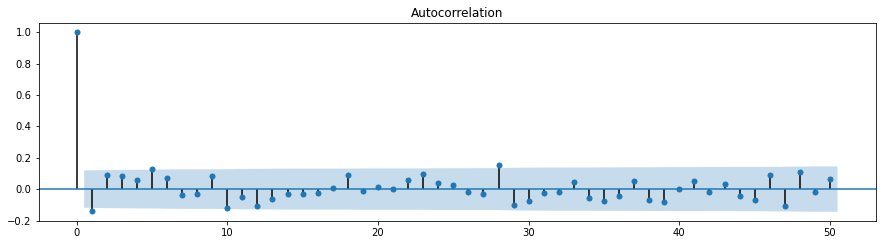

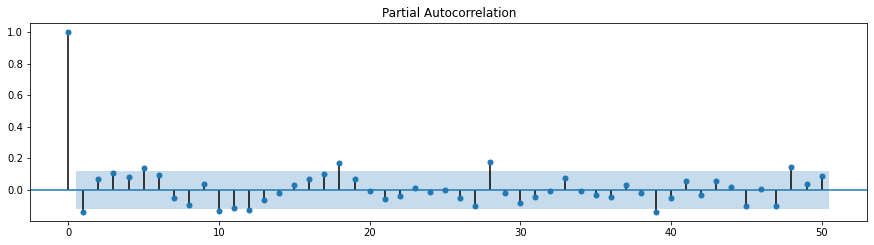

In [8]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['WAG_C_M_diff2'][13:].values.squeeze(), lags=50, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['WAG_C_M_diff2'][13:].values.squeeze(), lags=50, ax=ax)
plt.show()

Начальные приближения p=1, q=1, P=1, Q=0. Подберем параметры 

In [9]:
ps = range(2)
qs = range(2)
Ps = range(2)
Qs = 0
d = 1
D = 1
params = []
for i in range(2):
    for j in range(2):
        for k in range(2):
            for t in range(1):
                params.append((i, j, k, t))
params

[(0, 0, 0, 0),
 (0, 0, 1, 0),
 (0, 1, 0, 0),
 (0, 1, 1, 0),
 (1, 0, 0, 0),
 (1, 0, 1, 0),
 (1, 1, 0, 0),
 (1, 1, 1, 0)]

In [19]:
%%time
results = []
best_aic = float("inf")
for param in params:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data['WAG_C_M_boxcox'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

CPU times: user 1.65 s, sys: 39.4 ms, total: 1.69 s
Wall time: 940 ms


Лучшая модель

In [20]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     WAG_C_M_boxcox   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Fri, 28 Aug 2020   AIC                              0.341
Time:                                    14:52:25   BIC                             11.147
Sample:                                01-01-1993   HQIC                             4.679
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046     -2.838      0.005      -0.222      -0.041
sigma2         0.0573      0.004     15.137      0.000       0.050       0.065
===================================================================================
Ljung-Box (Q):                       55.80   Jarque-Bera (JB):                55.20
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             0.11
Prob(H) (two-sided):                  0.12   Kurtosis:                         5.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Посмотрим на остатки модели

Критерий Стьюдента: p = 0.09079523914680168
Критерий Дики-Фуллера: p = 3.4592156240846908e-06


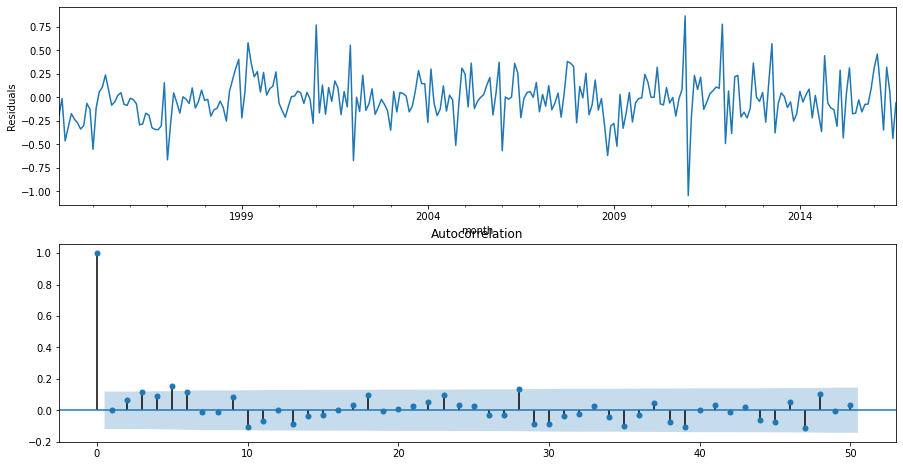

In [12]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=50, ax=ax)

print('Критерий Стьюдента: p = {}'.format(stats.ttest_1samp(best_model.resid[13:], 0)[1]))
print('Критерий Дики-Фуллера: p = {}'.format(sm.tsa.stattools.adfuller(best_model.resid[13:])[1]))

В остатках нет никакой структуры (подтверждается визуально и критериями), значит у существенной модели нет очевидных существенных недостатков. Посмотрим на график модели

In [13]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda * y + 1) / lmbda))
    

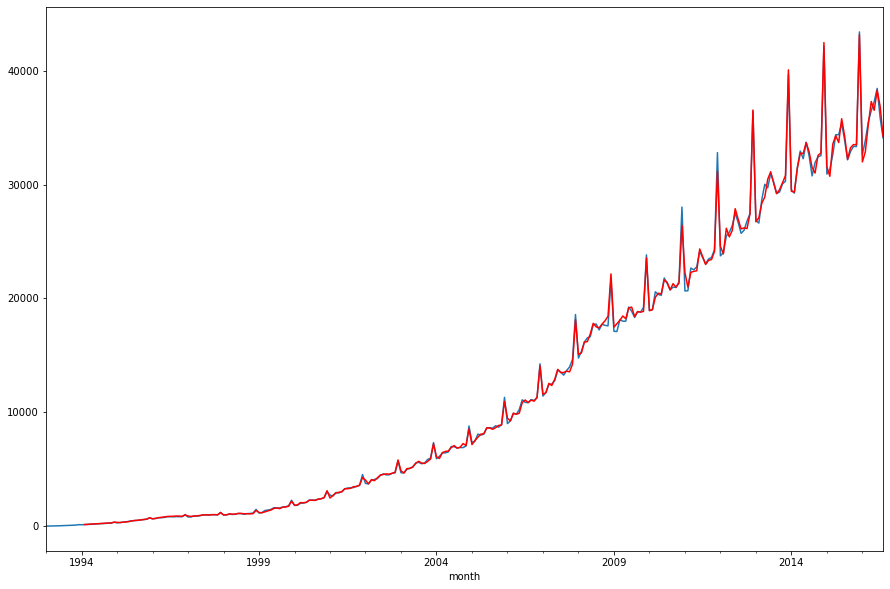

In [14]:
data['model'] = invboxcox(best_model.fittedvalues, lmbd)
plt.figure(figsize(15,10))
data['WAG_C_M'].plot()
data.model[13:].plot(color='r');

Как видно по графику, наша модель очень хорошо приближает данные. Проанализируем остатки.

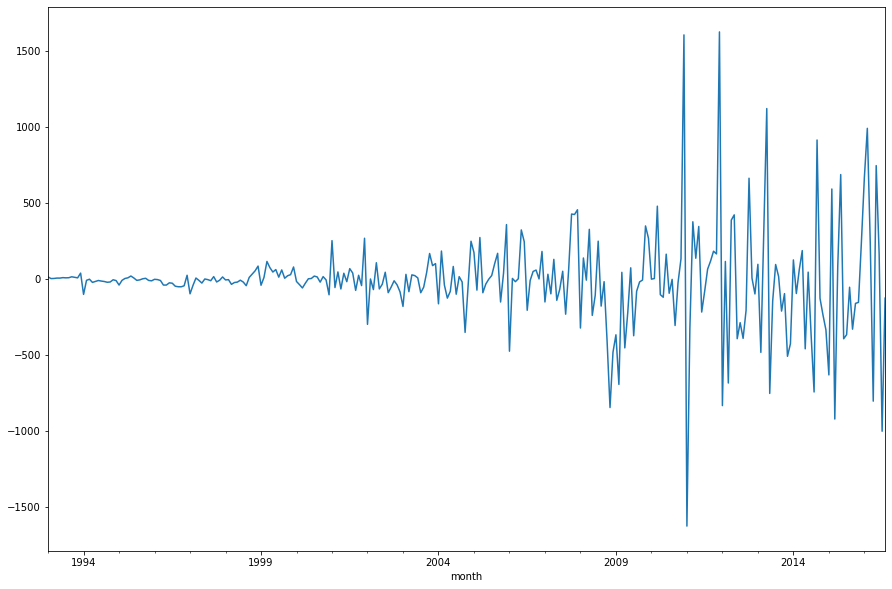

In [15]:
data['remains'] = data['WAG_C_M'] - data['model']
data['remains'].plot();

В остатках нет никакой структуры, они несмещенные. Сделаем прогноз

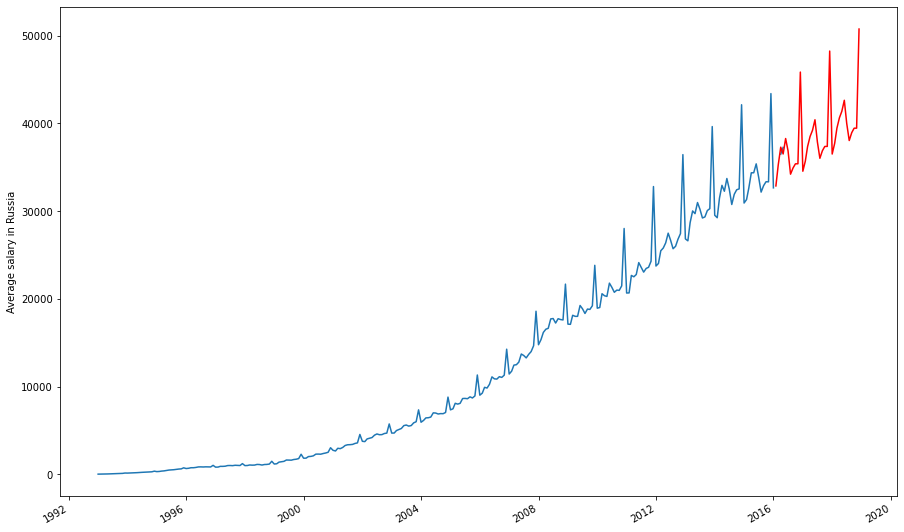

In [16]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime('2016-01-01', '%Y-%m-%d') + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=277, end=420), lmbd)

plt.figure(figsize(15,10))
data2['WAG_C_M'].plot()
data2['forecast'].plot(color='r')
plt.ylabel('Average salary in Russia')
plt.show()

По графику видно, что модель не противоречит здравому смыслу, все свойства ряда были сохранены